In [1]:
import sqlite3
import pandas as pd
import numpy as np


def trim_start_end_nans(df):
    """
    Removes rows at the start and end of a DataFrame that have NaN values in any column.
    """
    # Initialize start_idx and end_idx based on the DataFrame's index type
    if isinstance(df.index, pd.DatetimeIndex):
        start_idx = df.index[0]  # Assume first index is earliest; adjust if necessary
        end_idx = df.index[-1]  # Assume last index is latest; adjust if necessary
    else:
        start_idx = 0
        end_idx = len(df) - 1

    for column in df.columns:
        # Find the first non-NaN index in the current column
        first_valid_index = df[column].first_valid_index()
        if first_valid_index is not None and df.index.get_loc(first_valid_index) > df.index.get_loc(start_idx):
            start_idx = first_valid_index

        # Find the last non-NaN index in the current column
        last_valid_index = df[column].last_valid_index()
        if last_valid_index is not None and df.index.get_loc(last_valid_index) < df.index.get_loc(end_idx):
            end_idx = last_valid_index

    # Trim the DataFrame
    return df.loc[start_idx:end_idx]

# Now, apply the updated function to the DataFrame

def process_data_for_plot(plot_number, start_date='2023-07-20', end_date='2023-09-03'):
    """
    Process data for a given plot number within a specified date range.

    Parameters:
    - plot_number: The plot number to filter the data by.
    - start_date: The start date of the period to filter the data.
    - end_date: The end date of the period to filter the data.

    Returns:
    - A processed DataFrame with the data for the specified plot and date range.
    """
    # Connect to the database and load data
    conn = sqlite3.connect('processed_data.db')
    query = 'SELECT * from data_table'
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Filter by plot_number
    df = df[df['plot_number'] == plot_number]

    # Filter by date range
    df = df[(df['TIMESTAMP'] >= start_date) & (df['TIMESTAMP'] <= end_date)]

    # Timestamp cyclical encoding
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df['day_sin'] = np.sin(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
    df['day_cos'] = np.cos(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
    df['hour_sin'] = np.sin(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
    df['hour_cos'] = np.cos(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
    df['dow_sin'] = np.sin(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)
    df['dow_cos'] = np.cos(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)

    # Define columns for processing
    time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
    target_columns = ['VWC_06', 'VWC_18', 'VWC_30', 'VWC_42']  # Adjust if necessary

    # Columns for correlation matrix
    corr_columns = [
        'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 
        'Dp_2m_Avg', 'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg', 
        'canopy_temp', 'VWC_06', 'VWC_18', 'VWC_30', 'VWC_42', 
        'daily_et', 'CWSI', 'SWSI', 'precip_irrig'
    ]

    # Eliminate duplicate indices and set TIMESTAMP as index
    df = df.drop_duplicates().set_index('TIMESTAMP').sort_index()

    # Assuming trim_start_end_nans is a predefined function to handle NaN values
    df = trim_start_end_nans(df)

    # Interpolate missing values
    df = df[corr_columns + time_columns].interpolate(method='pchip')

    return df



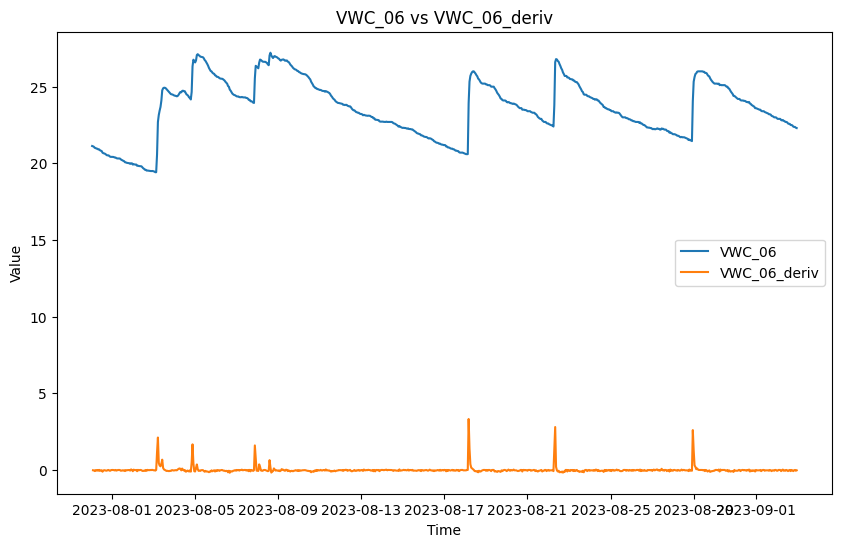

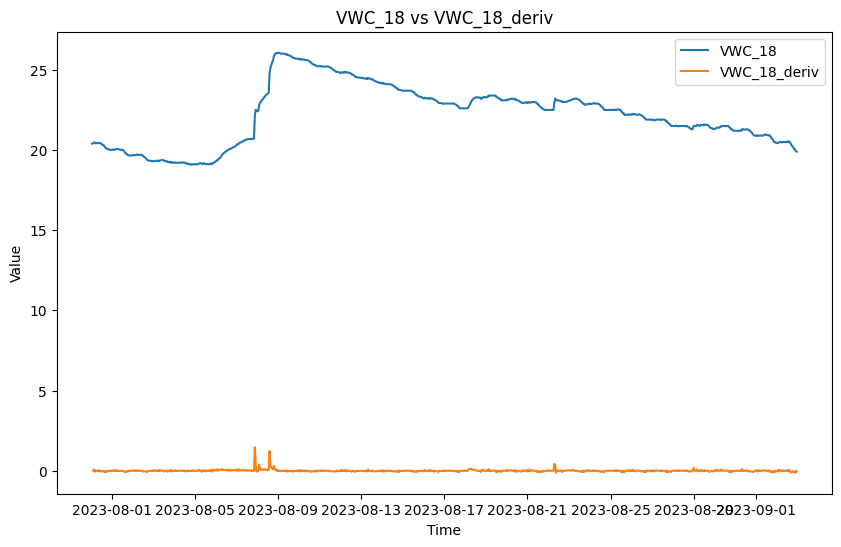

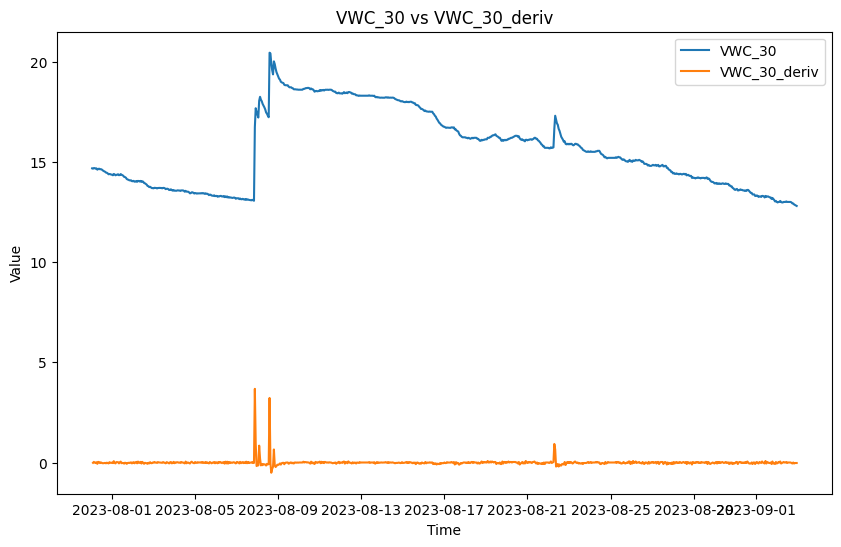

Derived DataFrame:                      Ta_2m_Avg  RH_2m_Avg  Solar_2m_Avg  WndAveSpd_3m  \
TIMESTAMP                                                               
2023-07-31 01:00:00  28.566000  71.488000     16.378667      1.954283   
2023-07-31 02:00:00  26.562000  80.442333      0.000000      1.581950   
2023-07-31 03:00:00  25.184333  85.723333      0.000000      2.321450   
2023-07-31 04:00:00  24.316167  88.250000      0.000000      1.875700   
2023-07-31 05:00:00  23.755500  89.378333      0.000000      2.809600   

                     Rain_1m_Tot  Dp_2m_Avg   TaMax_2m   TaMin_2m   RHMax_2m  \
TIMESTAMP                                                                      
2023-07-31 01:00:00          0.0  22.891500  28.706667  28.412667  71.650000   
2023-07-31 02:00:00          0.0  22.917833  26.711500  26.411667  80.580500   
2023-07-31 03:00:00          0.0  22.623833  25.318333  25.042667  85.860000   
2023-07-31 04:00:00          0.0  22.249667  24.465000  24.168000  88

INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 18s 1s/step - loss: 19.2228 - val_loss: 16.6664
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 14.8212
Epoch 2: val_loss improved from 16.66640 to 12.74887, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 23s 2s/step - loss: 14.8212 - val_loss: 12.7489
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: 11.0936
Epoch 3: val_loss improved from 12.74887 to 9.37493, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 23s 2s/step - loss: 11.0936 - val_loss: 9.3749
Epoch 4/20
14/14 [==============================] - ETA: 0s - loss: 7.9648
Epoch 4: val_loss improved from 9.37493 to 6.53488, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 19s 1s/step - loss: 7.9648 - val_loss: 6.5349
Epoch 5/20
14/14 [==============================] - ETA: 0s - loss: 5.3763
Epoch 5: val_loss improved from 6.53488 to 4.22877, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 19s 1s/step - loss: 5.3763 - val_loss: 4.2288
Epoch 6/20
14/14 [==============================] - ETA: 0s - loss: 3.3133
Epoch 6: val_loss improved from 4.22877 to 2.45801, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 16s 1s/step - loss: 3.3133 - val_loss: 2.4580
Epoch 7/20
14/14 [==============================] - ETA: 0s - loss: 1.7794
Epoch 7: val_loss improved from 2.45801 to 1.21209, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 11s 848ms/step - loss: 1.7794 - val_loss: 1.2121
Epoch 8/20
14/14 [==============================] - ETA: 0s - loss: 0.7613
Epoch 8: val_loss improved from 1.21209 to 0.45514, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 11s 861ms/step - loss: 0.7613 - val_loss: 0.4551
Epoch 9/20
14/14 [==============================] - ETA: 0s - loss: 0.2603
Epoch 9: val_loss improved from 0.45514 to 0.23909, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 11s 815ms/step - loss: 0.2603 - val_loss: 0.2391
Epoch 10/20
14/14 [==============================] - ETA: 0s - loss: 0.1442
Epoch 10: val_loss improved from 0.23909 to 0.16359, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 11s 788ms/step - loss: 0.1442 - val_loss: 0.1636
Epoch 11/20
14/14 [==============================] - ETA: 0s - loss: 0.0962
Epoch 11: val_loss improved from 0.16359 to 0.13592, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 15s 1s/step - loss: 0.0962 - val_loss: 0.1359
Epoch 12/20
14/14 [==============================] - ETA: 0s - loss: 0.0809
Epoch 12: val_loss did not improve from 0.13592
14/14 [==============================] - 12s 910ms/step - loss: 0.0809 - val_loss: 0.1380
Epoch 13/20
14/14 [==============================] - ETA: 0s - loss: 0.0751
Epoch 13: val_loss improved from 0.13592 to 0.12690, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 30s 2s/step - loss: 0.0751 - val_loss: 0.1269
Epoch 14/20
14/14 [==============================] - ETA: 0s - loss: 0.0732
Epoch 14: val_loss improved from 0.12690 to 0.12503, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 28s 2s/step - loss: 0.0732 - val_loss: 0.1250
Epoch 15/20
14/14 [==============================] - ETA: 0s - loss: 0.0729
Epoch 15: val_loss did not improve from 0.12503
14/14 [==============================] - 6s 417ms/step - loss: 0.0729 - val_loss: 0.1391
Epoch 16/20
14/14 [==============================] - ETA: 0s - loss: 0.0726
Epoch 16: val_loss improved from 0.12503 to 0.12347, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 13s 960ms/step - loss: 0.0726 - val_loss: 0.1235
Epoch 17/20
14/14 [==============================] - ETA: 0s - loss: 0.0719
Epoch 17: val_loss did not improve from 0.12347
14/14 [==============================] - 6s 400ms/step - loss: 0.0719 - val_loss: 0.1252
Epoch 18/20
14/14 [==============================] - ETA: 0s - loss: 0.0719
Epoch 18: val_loss did not improve from 0.12347
14/14 [==============================] - 6s 470ms/step - loss: 0.0719 - val_loss: 0.1288
Epoch 19/20
14/14 [==============================] - ETA: 0s - loss: 0.0714
Epoch 19: val_loss did not improve from 0.12347
14/14 [==============================] - 5s 386ms/step - loss: 0.0714 - val_loss: 0.1276
Epoch 20/20
14/14 [==============================] - ETA: 0s - loss: 0.0714
Epoch 20: val_loss did not improve from 0.12347
14/14 [==============================] - 5s 387ms/step - loss: 0.0714 - val_loss: 0.1298


In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2 
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter

def subtract_mean(df, target_columns, keep_original_cols=True):
    mean_values = {}
    for col in target_columns:
        mean_value = df[col].mean()
        # When keep_original_cols is True, subtract the mean from a new column
        if keep_original_cols:
            new_col_name = f"{col}_mean_subtracted"
            df[new_col_name] = df[col] - mean_value
        else:
            df[col] -= mean_value
        mean_values[col] = mean_value
    return df, mean_values



def create_derivative_columns(df, target_columns, keep_original_cols=True):
    """Calculates difference-based derivatives of specified columns.

    Args:
        df: Pandas DataFrame containing the data.
        target_columns: List of columns for which derivatives are calculated.
        keep_original_cols: If True, creates new columns; otherwise overwrites.

    Returns:
        DataFrame with derivative columns, plus initial values if needed.
    """

    initial_values = {}  # Store initial values for reconstruction

    for col in target_columns:
        deriv_col_name = f"{col}_deriv"

        if keep_original_cols:
            df[deriv_col_name] = df[col].diff()  # Calculate differences
        else:
            initial_values[col] = df[col].iloc[0]  # Store initial value
            df[col] = df[col].diff()  

        # Plot the original and derived columns
        plt.figure(figsize=(10, 6))
        plt.plot(df[col], label=col)
        plt.plot(df[deriv_col_name], label=deriv_col_name)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'{col} vs {deriv_col_name}')
        plt.legend()
        plt.show()
        
    print(f"Derived DataFrame: {df.head()}")

    return df, initial_values  # Return initial values as well


def scale_dataframe(df, target_columns):
    other_scaler = MinMaxScaler()
    # Scale target columns
    target_scaler = MinMaxScaler()
    df[target_columns] = target_scaler.fit_transform(df[target_columns])
    
    # Scale other columns
    other_columns = [col for col in df.columns if col not in target_columns]
    df[other_columns] = other_scaler.fit_transform(df[other_columns])
    
    # Return only the scaler for target columns
    return df, target_scaler

def transform_and_scale_data(df, target_columns, continuous_columns, time_columns, keep_original_cols=True):
    """
    Transforms and scales the data in the DataFrame for neural network input, but only returns the
    scaler for the target columns.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_columns (list): List of target column names.
        continuous_columns (list): List of continuous column names.
        time_columns (list): List of time column names.
        keep_original_cols (bool): If True, keeps original columns unchanged except for scaling;
                                   if False, applies transformations directly on the target columns.

    Returns:
        pd.DataFrame: The transformed and scaled DataFrame.
        dict: A dictionary containing transformation metadata for the target columns.
        int: The number of columns in the transformed DataFrame.
    """

    # Copy DataFrame to avoid modifying the original
    df_transformed = df.copy()

    # Apply transformations directly using helper functions
    # The order of the transformations is important: derivative -> mean subtraction -> scaling
    df_transformed, initial_values = create_derivative_columns(df_transformed, target_columns, keep_original_cols)
    
    # Delete the first row of the DataFrame since it contains NaN values
    df_transformed = df_transformed.iloc[1:]
    
    df_transformed, mean_values = subtract_mean(df_transformed, target_columns, keep_original_cols)
    df_transformed, target_scaler = scale_dataframe(df_transformed, target_columns)
    
    # print scaled dataframe
    print(f"Scaled DataFrame: {df_transformed.head()}")

    # Prepare metadata for reverse transformation
    transformation_metadata = {
        'means': mean_values,
        'target_scaler': target_scaler,
        'keep_original_cols': keep_original_cols,
        'initial_values': initial_values
    }

    # Calculate the number of columns after transformation
    num_columns = len(df_transformed.columns)

    return df_transformed, transformation_metadata, num_columns


def reverse_transform_and_scale_data(df, transformation_metadata, keep_original_cols=True):
    """
    Reverses the transformations and scaling applied to the DataFrame.

    Args:
        df (pd.DataFrame): The transformed and scaled DataFrame.
        transformation_metadata (dict): A dictionary containing transformation metadata.
        keep_original_cols (bool): Indicates whether original columns were kept unchanged.

    Returns:
        pd.DataFrame: The DataFrame with reversed transformations and scaling.
    """

    # Extract metadata
    target_scaler = transformation_metadata['target_scaler']
    mean_values = transformation_metadata['means']
    initial_values = transformation_metadata['initial_values']
    target_columns = [col for col in mean_values]  # Assumes mean_values only has target columns

    # Print dimensions of df
    print(f"Shape of input DataFrame: {df.shape}")

    # Print scaler shape
    print(f"Shape of scaler scale_ attribute: {target_scaler.scale_.shape}")

    # Reverse scale the target columns
    df[target_columns] = target_scaler.inverse_transform(df[target_columns])

    # Apply undifferencing with cumsum() and initial values if original columns were not kept
    if not keep_original_cols:
        for column in target_columns:
            # Reverse subtract mean from target columns if they were mean-adjusted
            if column in mean_values:
                df[column] = df[column] + mean_values[column]
                print(f"Reversed mean for {column}: ", df[column].head())

            # Apply cumsum() to reverse the differencing using initial values
            if column in initial_values:
                df[column] = df[column].cumsum() + initial_values[column]
                print(f"Undifferenced {column}: ", df[column].head())

    return df



# Sequence Creation Function
def create_sequences(input_data, target_data, input_window, forecast_horizon, stride=1):
    X, y = [], []
    for start in range(len(input_data) - input_window - forecast_horizon + stride):
        end = start + input_window
        X.append(input_data[start:end])
        y.append(target_data[end:end + forecast_horizon])
    return np.array(X), np.array(y)

# Model Definition Function for 4 Target Variables
def build_model(input_shape, num_targets):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.01)), 
        Dropout(0.2),
        LSTM(64, return_sequences=True, kernel_regularizer=l1(0.01)),  
        Dropout(0.2),
        LSTM(36, return_sequences=False),
        Dense(96 * num_targets), 
        Reshape((96, num_targets)) 
    ])
    model.compile(optimizer='adam', loss='mse')
    return model



def chronological_split(X, y, test_size=0.2):
    # Calculate the index to split the data
    total_samples = len(X)
    split_index = int(total_samples * (1 - test_size))
    
    # Split the data chronologically
    X_train = X[:split_index]
    X_val = X[split_index:]
    y_train = y[:split_index]
    y_val = y[split_index:]
    
    return X_train, X_val, y_train, y_val


# Main Function to Execute Workflow
def run_workflow(df_processed, plot_number, time_columns, continuous_columns, target_variables,
                 input_window, forecast_horizon, stride, epochs, batch_size):
    
    print(f"df_processed shape: {df_processed.shape}")
    print(f"df_processed columns: {df_processed.columns}")
    print(f"df_processed head: {df_processed.head()}")
    
    input_data = df_processed.values
    X, y = create_sequences(input_data, df_processed[target_variables].values, input_window, forecast_horizon)    
    
    X_train, X_val, y_train, y_val = chronological_split(X, y)

    model = build_model((input_window, X.shape[2]), len(target_variables))

    # Define the checkpoint path and directory
    checkpoint_path = f"./LSTM_{plot_number}"

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=False,
                                                     monitor='val_loss',
                                                     mode='min',
                                                     save_best_only=True,
                                                     
                                                     verbose=1)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit model with callbacks
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, cp_callback])
    
    return checkpoint_path


# Example Usage
plot_number = 2014


# Initialize a dict to store models, scalers, and added columns keyed by plot number
plot_data = {}

scalers = {}

# *** Important: Update the target_columns and continuous_columns based on your chosen target columns ***
# *** Any columns included in target_columns should be removed from continuous_columns ***
target_columns = ['VWC_06', 'VWC_18', 'VWC_30']
time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
continuous_columns = [
    'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 'Rain_1m_Tot', 'Dp_2m_Avg',
    'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg',
    'daily_et', 'CWSI', 'SWSI', 'irrigation', 'precip_irrig'
]
derivative_columns = ['precip_irrig']

input_window = 168
forecast_horizon = 96
stride = 1
epochs = 20
batch_size = 32  # Adjust based on your dataset size and memory capacity

# process data and get the scaler for unscaling the predictions
df= process_data_for_plot(plot_number) 
df_transformed, transformation_metadata, num_columns = transform_and_scale_data(df, target_columns, continuous_columns, time_columns, keep_original_cols=True)

# run the workflow for training the model
checkpoint_path = run_workflow(df_transformed, plot_number, time_columns, continuous_columns, target_columns, 
                                      input_window, forecast_horizon, stride, epochs, batch_size)


    


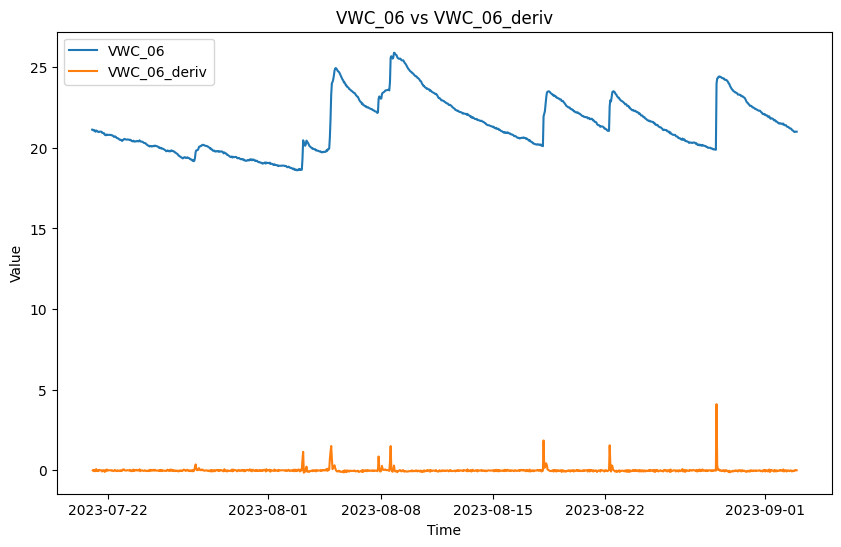

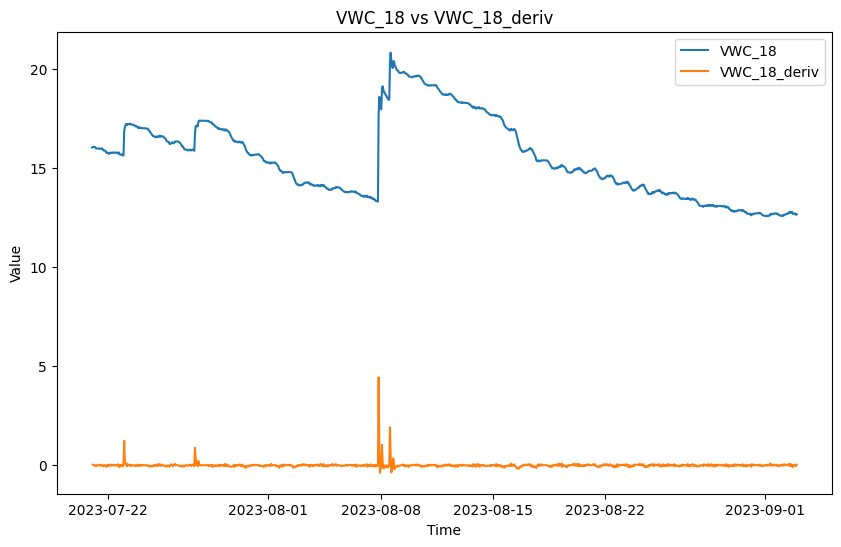

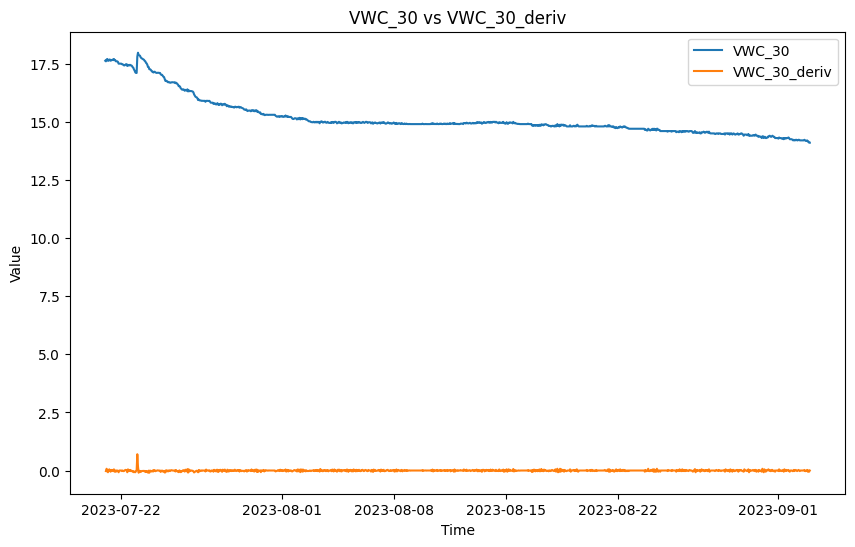

Derived DataFrame:                      Ta_2m_Avg  RH_2m_Avg  Solar_2m_Avg  WndAveSpd_3m  \
TIMESTAMP                                                               
2023-07-21 00:00:00  19.792500  82.012167     12.659683      0.840067   
2023-07-21 01:00:00  18.195167  91.986667      1.783867      1.341067   
2023-07-21 02:00:00  17.453000  91.310000      0.000000      1.300250   
2023-07-21 03:00:00  16.979167  95.956667      0.000000      0.428883   
2023-07-21 04:00:00  16.768833  97.473333      0.000000      0.275517   

                     Rain_1m_Tot  Dp_2m_Avg   TaMax_2m   TaMin_2m   RHMax_2m  \
TIMESTAMP                                                                      
2023-07-21 00:00:00        0.000  16.625667  19.932500  19.646833  82.608833   
2023-07-21 01:00:00        2.032  16.868333  18.332000  18.042667  92.203333   
2023-07-21 02:00:00        0.254  16.019833  17.594000  17.293500  91.528333   
2023-07-21 03:00:00        0.254  16.331000  17.114667  16.826167  96

c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\sklearn\preprocessing\_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


1/1 [==============================] - 1s 834ms/step
Predicted shape: (1, 96, 3)
Predicted: [[[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]
  [nan nan n

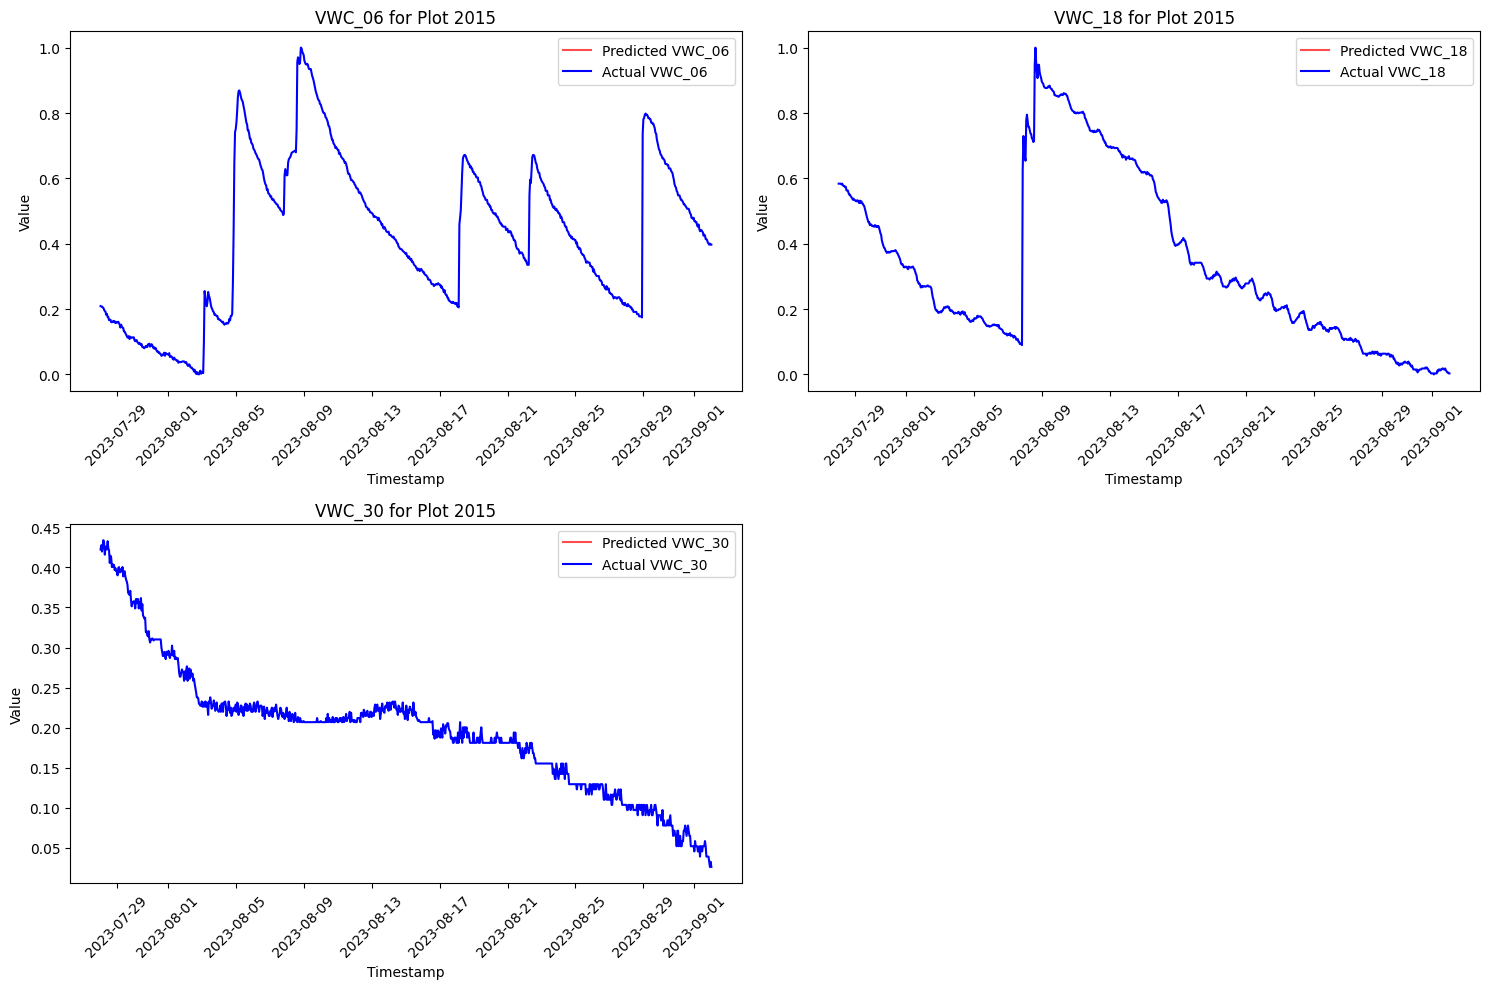

Shape of input DataFrame: (864, 3)
Shape of scaler scale_ attribute: (3,)
Shape of input DataFrame: (864, 3)
Shape of scaler scale_ attribute: (3,)
Values of predictions_df  and actuals_df after reverse transformation and scaling
                     VWC_06  VWC_18  VWC_30
TIMESTAMP                                  
2023-07-28 01:00:00     NaN     NaN     NaN
2023-07-28 02:00:00     NaN     NaN     NaN
2023-07-28 03:00:00     NaN     NaN     NaN
2023-07-28 04:00:00     NaN     NaN     NaN
2023-07-28 05:00:00     NaN     NaN     NaN
                        VWC_06     VWC_18     VWC_30
TIMESTAMP                                           
2023-07-28 01:00:00  21.050641  23.162753  16.029864
2023-07-28 02:00:00  21.039949  23.162753  16.069373
2023-07-28 03:00:00  21.039949  23.162753  16.010110
2023-07-28 04:00:00  21.018563  23.162753  16.069373
2023-07-28 05:00:00  21.007870  23.145850  16.118760
Plotting predictions and actuals after reverse transformation and scaling


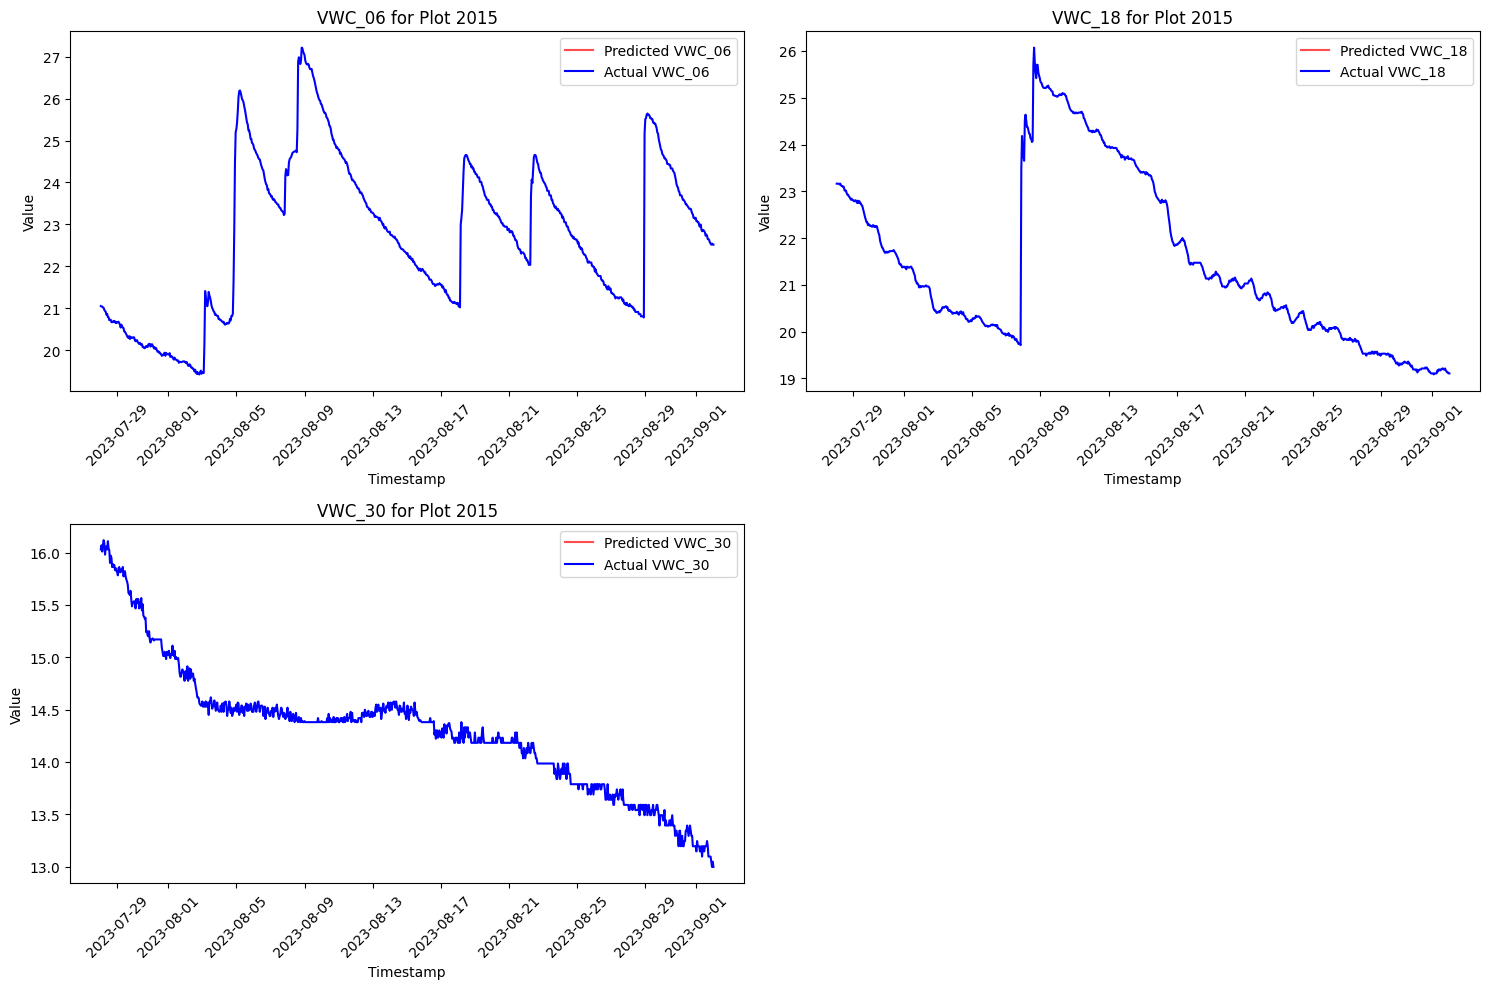

Transformation metadata: {'means': {'VWC_06': 23.591772357723578, 'VWC_18': 22.209748983739832, 'VWC_30': 15.588443089430896}, 'target_scaler': MinMaxScaler(), 'keep_original_cols': True, 'initial_values': {}}


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

def plot_predictions(predictions_df, actuals_df, target_columns, plot_number):
        num_plots = len(target_columns)
        num_rows = int(np.ceil(num_plots / 2))  # You can adjust the number of columns per row if you like
        plt.figure(figsize=(15, 5 * num_rows))  # Adjust the figure size as needed
        for i, column in enumerate(target_columns):
            plt.subplot(num_rows, 2, i + 1)  # Adjust the number of columns per row if you like
            plt.plot(predictions_df.index, predictions_df[column], label=f'Predicted {column}', color='red', alpha=0.7)
            plt.plot(actuals_df.index, actuals_df[column], label=f'Actual {column}', color='blue')
            plt.legend()
            plt.title(f'{column} for Plot {plot_number}')  
            plt.xlabel('Timestamp')
            plt.ylabel('Value')
            plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def predict_with_sliding_window(model, df, transformation_metadata, time_columns, continuous_columns, target_columns, input_window, forecast_horizon, plot_number):
    # Create input& target data, input data is all columns except target columns
    target_data = df[target_columns].values
    input_data = df.values
    predictions = []
    actuals = []
    timestamps = []
    
    # Adjust stride based on prediction: 1 for continuous sliding
    stride = forecast_horizon
    for start in range(0, len(df) - input_window - forecast_horizon + 1, stride):
        end = start + input_window
        if end + forecast_horizon > len(input_data):
            break
        sequence = input_data[start:end]
        sequence = sequence.reshape((1, input_window, len(input_data[0])))
        
        print(f"Sequence shape: {sequence.shape}")
        print(f"Sequence: {sequence}")
        
        pred = model.predict(sequence)
        
        print(f"Predicted shape: {pred.shape}")
        print(f"Predicted: {pred}")
        
        pred = pred.reshape(-1, pred.shape[-1])
        predictions.append(pred)  
        actuals.append(target_data[end:end + forecast_horizon])
        timestamp_series = pd.Series(df.index[end:end + forecast_horizon], index=df.index[end:end + forecast_horizon])
        timestamps.append(timestamp_series)
        
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    timestamps = pd.concat(timestamps)

    
    # Create the DataFrame with the reshaped predictions and the correct timestamps
    predictions_df = pd.DataFrame(predictions, columns=target_columns, index=timestamps)
    actuals_df = pd.DataFrame(actuals, columns=target_columns, index=timestamps)
    
    # Apply reverse transformation and scaling to both predictions and actuals
    
    # Plot the predictions and actuals before reverse transformation and scaling
    print("Plotting predictions and actuals before reverse transformation and scaling")
    print("Values of predictions_df  and actuals_df before reverse transformation and scaling")
    print(predictions_df.head())
    print(actuals_df.head())
    plot_predictions(predictions_df, actuals_df, target_columns, plot_number)

    # Apply reverse transformation and scaling to both predictions and actuals
    predictions_df = reverse_transform_and_scale_data(predictions_df, transformation_metadata)
    actuals_df = reverse_transform_and_scale_data(actuals_df, transformation_metadata)

    # Example usage
    print("Values of predictions_df  and actuals_df after reverse transformation and scaling")
    print(predictions_df.head())
    print(actuals_df.head())
    print("Plotting predictions and actuals after reverse transformation and scaling")
    plot_predictions(predictions_df, actuals_df, target_columns, plot_number)
    
    # verbosely print contents of transformation_metadata
    print(f"Transformation metadata: {transformation_metadata}")
    
    return predictions_df, actuals_df, timestamps

# Array of plot numbers
plot_numbers = [2015, 2001, 2013, 2007]
#plot_numbers = [2015]

# initialize predictions_df and actuals_df and timestamps as empty dataframes
predictions_df = pd.DataFrame()
actuals_df = pd.DataFrame()
timestamps = pd.Series()

# Loop through plot numbers
for plot_number in plot_numbers:
    model = tf.keras.models.load_model(checkpoint_path)
    df_plot = process_data_for_plot(plot_number)
    df_plot, _ , num_columns = transform_and_scale_data(df_plot, target_columns, continuous_columns, time_columns, keep_original_cols=True)
    predictions_df, actuals_df, timestamps = predict_with_sliding_window(model, df_plot, transformation_metadata, time_columns=time_columns, continuous_columns=continuous_columns, target_columns=target_columns, input_window=24*7, forecast_horizon=96, plot_number=plot_number)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2 
from keras_self_attention import SeqSelfAttention


from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter

def subtract_mean(df, target_columns):
    mean_values = {}
    for col in target_columns:
        mean_value = df[col].mean()
        df.loc[:, col] -= mean_value
        mean_values[col] = mean_value
    return df, mean_values

def create_derivative_columns(df, target_columns):
    for col in target_columns:
        deriv_col_name = f"{col}_deriv"
        df[deriv_col_name] = savgol_filter(df[col], window_length=5, polyorder=2, deriv=1)
    return df

def scale_dataframe(df, columns):
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df, scaler

from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

def transform_and_scale_data(df, target_columns, continuous_columns, time_columns, keep_original_cols=True):
    """
    Transforms and scales the data in the DataFrame for neural network input, but only returns the
    scaler for the target columns.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_columns (list): List of target column names.
        continuous_columns (list): List of continuous column names.
        time_columns (list): List of time column names.
        keep_original_cols (bool): If True, keeps original columns unchanged except for scaling;
                                   if False, applies transformations directly on the target columns.

    Returns:
        pd.DataFrame: The transformed and scaled DataFrame.
        dict: A dictionary containing transformation metadata for the target columns.
        int: The number of columns in the transformed DataFrame.
    """

    # Prepare DataFrame
    df_transformed = df.copy()
    df_transformed = df_transformed[continuous_columns + time_columns + target_columns]

    # Initialize scaler for all columns
    full_scaler = MinMaxScaler()
    # Initialize scaler for target columns
    target_scaler = MinMaxScaler()

    # If keeping original cols, create new columns to apply transformations
    if keep_original_cols:
        # Subtract mean from target columns and create derivative columns
        print(df_transformed.shape, len(target_columns))
        df_transformed, mean_values = subtract_mean(df_transformed, target_columns)
        print(df_transformed.shape, len(target_columns), mean_values)
        df_transformed = create_derivative_columns(df_transformed, target_columns)
    else:
        # Directly apply mean subtraction on target columns
        print(df_transformed.shape, len(target_columns))
        df_transformed, mean_values = subtract_mean(df_transformed, target_columns)
        print(df_transformed.shape, len(target_columns), mean_values)

    # Scale the target columns using the target_scaler
    df_transformed[target_columns] = target_scaler.fit_transform(df_transformed[target_columns])
    print(f"Scaler fitted on target columns with shape: {df_transformed[target_columns].shape}")

    # Scale all other columns using the full_scaler
    all_other_columns = list(set(df_transformed.columns) - set(target_columns))
    df_transformed[all_other_columns] = full_scaler.fit_transform(df_transformed[all_other_columns])
    print(f"All other columns scaled with shape: {df_transformed[all_other_columns].shape}")

    # Compile transformation metadata
    transformation_metadata = {
        'means': mean_values,
        'target_scaler': target_scaler,
        'keep_original_cols': keep_original_cols
    }

    # Count the number of columns for use in inference
    num_columns = len(df_transformed.columns)

    return df_transformed, transformation_metadata, num_columns




def reverse_transform_and_scale_data(df, transformation_metadata, keep_original_cols=True):
    """
    Reverses the transformations and scaling applied to the DataFrame.

    Args:
        df (pd.DataFrame): The transformed and scaled DataFrame.
        transformation_metadata (dict): A dictionary containing transformation metadata.
        keep_original_cols (bool): Indicates whether original columns were kept unchanged.

    Returns:
        pd.DataFrame: The DataFrame with reversed transformations and scaling.
    """

    # Extract metadata
    target_scaler = transformation_metadata['target_scaler']
    mean_values = transformation_metadata['means']
    target_columns = [col for col in mean_values]  # Assumes mean_values only has target columns

    # Print dimensions of df
    print(f"Shape of input DataFrame: {df.shape}")

    # Print scaler shape
    print(f"Shape of scaler scale_ attribute: {target_scaler.scale_.shape}")

    # Reverse scale the target columns
    df[target_columns] = target_scaler.inverse_transform(df[target_columns])

    # If keep_original_cols is True, there should be no mean subtraction to reverse
    if not keep_original_cols:
        # Reverse subtract mean from target columns
        for column, mean_value in mean_values.items():
            if column in df.columns:
                df[column] = df[column] + mean_value
                print(f"Reversed mean subtraction for column: {column}")

    return df






# Sequence Creation Function
def create_sequences(input_data, target_data, input_window, forecast_horizon, stride=1):
    X, y = [], []
    for start in range(len(input_data) - input_window - forecast_horizon + stride):
        end = start + input_window
        X.append(input_data[start:end])
        y.append(target_data[end:end + forecast_horizon])
    return np.array(X), np.array(y)

# Model Definition Function for 4 Target Variables
def build_model(input_shape, num_targets):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.01)), 
        SeqSelfAttention(attention_activation='sigmoid'),
        Dropout(0.2),
        LSTM(64, return_sequences=True, kernel_regularizer=l1(0.01)),  
        Dropout(0.2),
        LSTM(36, return_sequences=False),
        Dense(96 * num_targets), 
        Reshape((96, num_targets)) 
    ])
    model.compile(optimizer='adam', loss='mse')
    return model



def chronological_split(X, y, test_size=0.2):
    # Calculate the index to split the data
    total_samples = len(X)
    split_index = int(total_samples * (1 - test_size))
    
    # Split the data chronologically
    X_train = X[:split_index]
    X_val = X[split_index:]
    y_train = y[:split_index]
    y_val = y[split_index:]
    
    return X_train, X_val, y_train, y_val


# Main Function to Execute Workflow
def run_workflow(df_processed, plot_number, time_columns, continuous_columns, target_variables,
                 input_window, forecast_horizon, stride, epochs, batch_size):
    
    input_data = df_processed.values
    X, y = create_sequences(input_data, df_processed[target_variables].values, input_window, forecast_horizon)    
    
    X_train, X_val, y_train, y_val = chronological_split(X, y)

    model = build_model((input_window, X.shape[2]), len(target_variables))

    # Define the checkpoint path and directory
    checkpoint_path = f"./LSTM_{plot_number}"

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=False,
                                                     monitor='val_loss',
                                                     mode='min',
                                                     save_best_only=True,
                                                     
                                                     verbose=1)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit model with callbacks
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, cp_callback])
    
    return checkpoint_path


# Example Usage
plot_number = 2014


# Initialize a dict to store models, scalers, and added columns keyed by plot number
plot_data = {}

scalers = {}

# *** Important: Update the target_columns and continuous_columns based on your chosen target columns ***
# *** Any columns included in target_columns should be removed from continuous_columns ***
target_columns = ['VWC_06', 'VWC_18', 'VWC_30']
time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
continuous_columns = [
    'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 'Rain_1m_Tot', 'Dp_2m_Avg',
    'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg',
    'daily_et', 'CWSI', 'SWSI', 'irrigation', 'precip_irrig'
]

input_window = 168
forecast_horizon = 96
stride = 1
epochs = 20
batch_size = 32  # Adjust based on your dataset size and memory capacity

# process data and get the scaler for unscaling the predictions
df= process_data_for_plot(plot_number) 
df_transformed, transformation_metadata, num_columns = transform_and_scale_data(df, target_columns, continuous_columns, time_columns, keep_original_cols=True)

# run the workflow for training the model
checkpoint_path = run_workflow(df_transformed, plot_number, time_columns, continuous_columns, target_columns, 
                                      input_window, forecast_horizon, stride, epochs, batch_size)


    
